**This is the right codes for image colorization. (source and credit: https://www.instructables.com/id/Colorizing-Old-BW-Photos-and-Videos-With-the-Help-/)**

Downloat models for the colorization 

In [ ]:
! mkdir model 
! wget http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel -O ./model/colorization_release_v2.caffemodel
! wget http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2_norebal.caffemodel -O ./model/colorization_release_v2_norebal.caffemodel
! wget http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v1/colorization_release_v1.caffemodel -O ./model/colorization_release_v1.caffemodel

mkdir: cannot create directory ‘model’: File exists
--2020-09-09 22:23:30--  http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel
Resolving eecs.berkeley.edu (eecs.berkeley.edu)... 23.185.0.1, 2620:12a:8001::1
Connecting to eecs.berkeley.edu (eecs.berkeley.edu)|23.185.0.1|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel [following]
--2020-09-09 22:23:30--  https://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel
Connecting to eecs.berkeley.edu (eecs.berkeley.edu)|23.185.0.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://people.eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel [following]
--2020-09-09 22:23:30--  

Clone the finished repository to compare the content 

In [152]:
! rm -r AI-Colorization/

In [153]:
! git clone https://github.com/zhirongwang94/AI-Colorization.git

Cloning into 'AI-Colorization'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 79 (delta 27), reused 59 (delta 12), pack-reused 0
Unpacking objects: 100% (79/79), done.


In [154]:
! rm -r ./input_videos/

In [156]:
! mv ./AI-Colorization/input_videos/ ./

# Black and White Phote Colorization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

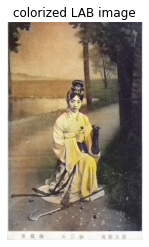

In [ ]:
# Import important libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2

#2 Define image to be colorized:
IMAGE = "mei1.png"

#3 Define Model Paths:
prototxt = "./model/colorization_deploy_v2.prototxt"
model = "./model/colorization_release_v2.caffemodel"
points = "./model/pts_in_hull.npy"
image =  "./input_images/"+IMAGE

#4 Load serialized black and white colorizer model and cluster: 
# (you need to have pts_in_hull.npy and colorization_deploy_v2.prototxt files 
# in model dirctory to continue)
net = cv2.dnn.readNetFromCaffe(prototxt, model)
pts = np.load(points)

#5 Add the cluster centers as 1x1 convolutions to the model:
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

#6  Load the input image, scale it and convert it to Lab:
#(if error occurs here, check if the IMAGE has the jpg extention )
image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

plt.imshow(image)
plt.axis('off');

#7 Extracting "L":
scaled = image.astype("float32") / 255.0
lab = cv2.cvtColor(scaled, cv2.COLOR_RGB2LAB)
resized = cv2.resize(lab, (224, 224))
L = cv2.split(resized)[0]
L -= 50

#8 Predicting "a" and "b":
net.setInput(cv2.dnn.blobFromImage(L))
ab = net.forward()[0, :, :, :].transpose((1, 2, 0))
ab = cv2.resize(ab, (image.shape[1], image.shape[0]))

#9. Creating a colorized Lab photo (L + a + b):
L = cv2.split(lab)[0]
colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

plt.imshow(colorized)
plt.axis('off');
plt.title('colorized LAB image');

#10. Converting to RGB:
colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2RGB)
colorized = np.clip(colorized, 0, 1)
colorized = (255 * colorized).astype("uint8")
plt.imshow(colorized)
plt.axis('off');

#11. Saving the final RGB photo:
cv2.imwrite("./colorized_images/Color_"+IMAGE, cv2.cvtColor(colorized, cv2.COLOR_RGB2BGR))

# Colorizing Videos

In [157]:
# import the necessary packages
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os
from os.path import isfile, join
from google.colab.patches import cv2_imshow
import cv2 



> 1. Start defining the file that should be colorized (that should be at the input_video folder:



In [158]:
VIDEO = "mengxiang1.mp4"

2. Define Paths, constants, and video variables:

In [159]:
# define paths
prototxt = "./model/colorization_deploy_v2.prototxt"
model = "./model/colorization_release_v2.caffemodel"
points = "./model/pts_in_hull.npy"
video =  "./input_videos/"+VIDEO
width = 500

vs = cv2.VideoCapture(video)


In [160]:
# load our serialized black and white colorizer model and cluster
# center points from disk

net = cv2.dnn.readNetFromCaffe(prototxt,model)
pts = np.load(points)

In [161]:

# add the cluster centers as 1x1 convolutions to the model
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

In [ ]:
from google.colab.patches import cv2_imshow
# cv2_imshow(img)

# loop over frames from the video stream
count = 0
success = True
while success:
	# grab the next frame and handle if we are reading from either
	# VideoCapture or VideoStream
	success, frame = vs.read()

	# if we are viewing a video and we did not grab a frame then we
	# have reached the end of the video
	if frame is None:
		break

	# resize the input frame, scale the pixel intensities to the
	# range [0, 1], and then convert the frame from the BGR to Lab
	# color space
	frame = imutils.resize(frame, 500)
	frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
	frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
	scaled = frame.astype("float32") / 255.0
	lab = cv2.cvtColor(scaled, cv2.COLOR_RGB2LAB)

	# resize the Lab frame to 224x224 (the dimensions the colorization
	# network accepts), split channels, extract the 'L' channel, and
	# then perform mean centering
	resized = cv2.resize(lab, (224, 224))
	L = cv2.split(resized)[0]
	L -= 50

	# pass the L channel through the network which will *predict* the
	# 'a' and 'b' channel values
	net.setInput(cv2.dnn.blobFromImage(L))
	ab = net.forward()[0, :, :, :].transpose((1, 2, 0))

	# resize the predicted 'ab' volume to the same dimensions as our
	# input frame, then grab the 'L' channel from the *original* input
	# frame (not the resized one) and concatenate the original 'L'
	# channel with the predicted 'ab' channels
	ab = cv2.resize(ab, (frame.shape[1], frame.shape[0]))
	L = cv2.split(lab)[0]
	colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

	# convert the output frame from the Lab color space to RGB, clip
	# any values that fall outside the range [0, 1], and then convert
	# to an 8-bit unsigned integer ([0, 255] range)
	colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
	colorized = np.clip(colorized, 0, 1)
	colorized = (255 * colorized).astype("uint8")

	# show the original and final colorized frames
  # cv2_imshow(img)
	cv2_imshow(frame)
	cv2_imshow(colorized)
    
	cv2.imwrite("./colorized_video_frames/frame%d.jpg" % count, colorized)
	count += 1
	key = cv2.waitKey(1) & 0xFF

	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

vs.release()

# close any open windows
cv2.destroyAllWindows()

In [163]:
def convert_frames_to_video(pathIn, pathOut, fps):
    frame_array = []
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
 
    #for sorting the file names properly
    files.sort(key = lambda x: int(x[5:-4]))
 
    for i in range(len(files)):
        filename=pathIn + files[i]
        #reading each files
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        print(filename)
        #inserting the frames into an image array
        frame_array.append(img)
 
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'MJPG'), fps, size)
 
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()

In [164]:
pathIn= './colorized_video_frames/'
pathOut = './colorized_videos/video.avi'
fps = 30.0
convert_frames_to_video(pathIn, pathOut, fps)

./colorized_video_frames/frame0.jpg
./colorized_video_frames/frame1.jpg
./colorized_video_frames/frame2.jpg
./colorized_video_frames/frame3.jpg
./colorized_video_frames/frame4.jpg
./colorized_video_frames/frame5.jpg
./colorized_video_frames/frame6.jpg
./colorized_video_frames/frame7.jpg
./colorized_video_frames/frame8.jpg
./colorized_video_frames/frame9.jpg
./colorized_video_frames/frame10.jpg
./colorized_video_frames/frame11.jpg
./colorized_video_frames/frame12.jpg
./colorized_video_frames/frame13.jpg
./colorized_video_frames/frame14.jpg
./colorized_video_frames/frame15.jpg
./colorized_video_frames/frame16.jpg
./colorized_video_frames/frame17.jpg
./colorized_video_frames/frame18.jpg
./colorized_video_frames/frame19.jpg
./colorized_video_frames/frame20.jpg
./colorized_video_frames/frame21.jpg
./colorized_video_frames/frame22.jpg
./colorized_video_frames/frame23.jpg
./colorized_video_frames/frame24.jpg
./colorized_video_frames/frame25.jpg
./colorized_video_frames/frame26.jpg
./colorized